# 両側に基づく緩和的な軸抽出

## 形状モデル
- 線対称の図形の軸が変形されてできる図形である
- 変形前の形状において、中心軸上の点 Po を通り、軸と直交する直線と両側の交点を Pl, Prとする。軸変形後 Po→Po', Pl→Pl', Pr→Prと位置が変わるものとする。この時、
>- Po'はPlとPr'の中点にある。
>- Po'Pl'=Po'Pl'=PoPl
>- Pl'Pr' と軸が直交

という関係は保存されるものと仮定。 

# アルゴリズム
1. 図形を平滑化し、重心と、軸が垂直になるよう図形を回転
2. 水平方向に向かい合う輪郭点のペアを上から順に (xl1,xr1),(xl2,xr2)...として抽出
3. 各ペアの中点を初期の中心軸点として点列をえる。
4. 中心軸点列にベジエ曲線を当てはめる。
5. 得られた曲線上の点における曲線の垂線と輪郭の交点を求め、ペアを更新する。
6. 得られたペアの中心を求め、中心軸点列を更新する。
7. 安定するまで繰り返す。

# 予備実験１

In [1]:
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import io
import skimage.data
import skimage.color
import os
import numpy as np
import cv2

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

# 処理結果画像（fimg)に処理前画像（bimg)の輪郭を描く
def draw2(bimg,fimg):
    if len(bimg.shape)==3:
        bimg2 = cv2.cvtColor(bimg,cv2.COLOR_BGR2GRAY)
    else:
        bimg2 = bimg.copy()
    if len(fimg.shape)==3:
        fimg2 = fimg.copy()
    else:
        fimg2 = cv2.cvtColor(fimg,cv2.COLOR_GRAY2BGR)
    # 処理前画像の輪郭
    # canvas = np.zeros_like(fimg2)
    canvas = fimg2.copy()
    _ret,bwimg = cv2.threshold(bimg2,128,255,cv2.THRESH_BINARY) # 白画素は255にする
    _img,cnt,hierarchy = cv2.findContours(bwimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # canvas = cv2.drawContours(canvas, cnt, -1, (255,230,230), thickness=-1)
    canvas = cv2.drawContours(canvas, cnt, -1, (255,0,200), thickness=1)
    # return cv2.addWeighted(fimg2, 0.5, canvas, 0.5,0)
    return canvas[:,:,::-1] # opencv -> PIL

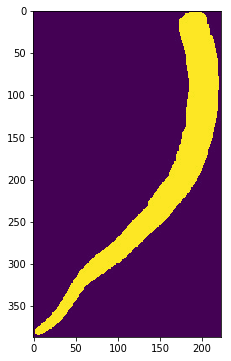

In [2]:
# src = cv2.imread('シルエット/17Apically/17daruma6o06_l.jpg')
# src = cv2.imread('シルエット/17Tran_ellip/17karami2o03_l.jpg')
# src = cv2.imread('シルエット/17Horn/17aomida1o02_l.jpg')
# src = cv2.imread('シルエット/17Tran_ellip/17heians1o07_l.jpg')
# path='シルエット/17Horn/17aomida1o02_l.jpg'
# path='シルエット/17Spheric/17yakumi2o06_l.jpg'
path ='シルエット/17Horn/17aomida1o02_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
fig = plt.figure(figsize=(8,6),dpi=72)
plt.imshow(src)

# 十分ぼかした上で重心と曲率最大点を結んで回転させてみる。

曲率を求める代わりにハリスコーナー検出器の識別結果を使ってみた。

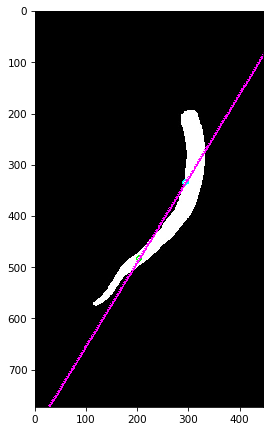

In [10]:
def getline_and_degree(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        s1 = int(x1 + 1000*dx)
        t1 = int(y1 + 1000*dy)
        s2 = int(x1 - 1000*dx)
        t2 = int(y1 - 1000*dy)
        if dx == 0:
            deg = 90
        elif dx >0:
            deg = 180.0*np.arctan(dy/dx)/np.pi
        else:
            deg = 180*(1+np.arctan(dy/dx)/np.pi)
        return s1,t1,s2,t2,deg

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

# 十分ぼかす
CONTOURS_APPROX = 0.005 # 輪郭近似精度
GAUSSIAN_RATE = 0.25 # ガウスぼかしをかける量
HARRIS_PARA = 1.0 # ハリスコーナー検出で、コーナーとみなすコーナーらしさの指標  1.0 なら最大値のみ

img = makemargin(src) # 作業用のマージンを確保
img2 = img.copy() # 加工前の状態を保存
# ガウスぼかしを適用してシルエットを滑らかにする
ksize = int(GAUSSIAN_RATE*img.shape[1]/2)*2+1 # ぼかし量  元の図形の幅に応じて決める
img = cv2.GaussianBlur(img,(ksize,ksize),0) # ガウスぼかしを適用
# ２値化してシルエットを求め直す
_ret,img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # ２値化
# Harris コーナ検出
himg = np.float32(img)
himg = cv2.cornerHarris(himg,blockSize=3,ksize=3,k=0.04)
# コーナー度合いが最大の領域を求める
wimg = np.zeros_like(img)
wimg[himg>=HARRIS_PARA*himg.max()]=255 # コーナー度最大値の領域を２５５で塗りつぶす。
# 最大値に等しい値の領域が１点とは限らないし、いくつかの点の塊になるかもしれない
_lnum, _img, cnt, goc = cv2.connectedComponentsWithStats(wimg)
areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
t_x,t_y = np.round(goc[areamax]) # 重心の位置

# コア全体の重心の位置を求める
_lnum, _img, _cnt, goc = cv2.connectedComponentsWithStats(img)
c_x,c_y = np.round(goc[1])

# コーナーの場所のマーキング（デバッグ用）
# himg = cv2.dilate(himg,None,iterations = 3)
# img3[himg>=HARRIS_PARA*himg.max()]=[0,0,255]

img3 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,7),dpi=75)
img3=cv2.circle(img3,(int(t_x),int(t_y)),5,(0,255,0),2)
img3=cv2.circle(img3,(int(c_x),int(c_y)),5,(255,255,0),2)
x1,y1,x2,y2,deg = getline_and_degree(c_x,c_y,t_x,t_y)
img3=cv2.line(img3,(x1,y1),(x2,y2),(255,0,255),2)                 
img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)
plt.subplot(122), plt.imshow(img3)
plt.show()

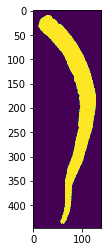

In [4]:
x1,y1,x2,y2,deg = getline_and_degree(c_x,c_y,t_x,t_y)

# 非常に稀であるが、回転すると全体が描画領域外に出ることがあるので作業領域を広く確保
# mat = cv2.getRotationMatrix2D((x0,y0), deg, 1.0) # アフィン変換マトリクス
img4 = makemargin(img2,mr=2) # 作業用のマージンを確保
h3,w3 = img2.shape[:2]
h4,w4 = img4.shape[:2]
mat = cv2.getRotationMatrix2D((c_x+(w4-w3)/2,c_y+(h4-h3)/2), deg-90, 1.0) # アフィン変換マトリクス

# アフィン変換の適用
img4 = cv2.warpAffine(img4, mat, (0,0),1)

# 再び最小矩形を求めて切り出す。ただし、マージンを５つける
_nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(img4) 
img4 = img4[data[1][1]-5:data[1][1]+data[1][3]+5,data[1][0]-5:data[1][0]+data[1][2]+5]

plt.imshow(img4)

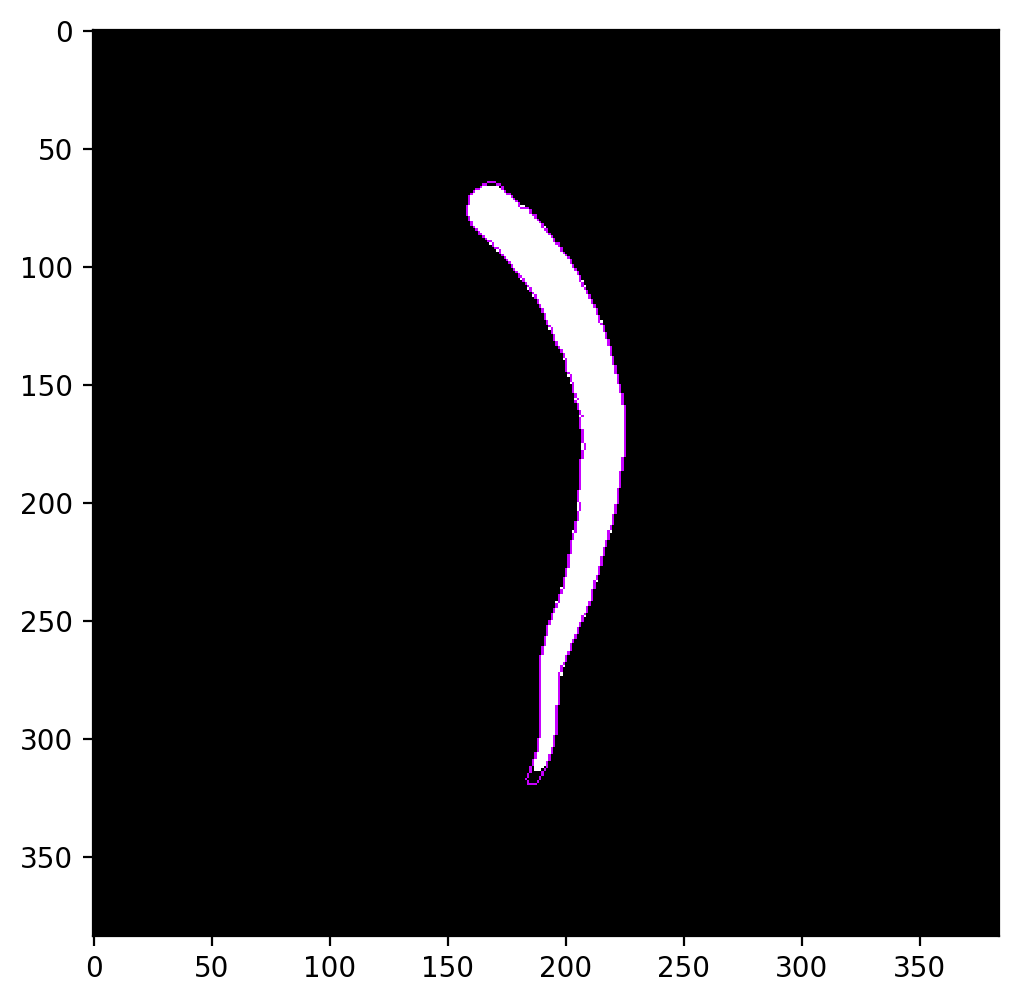

In [5]:
# 区分的にベジエ曲線で近似してみる
'シルエット/17Horn/17aomida1o02_l.jpg'
UNIT = 256 # 長い方の辺をこのサイズになるよう拡大縮小する
CONTOURS_APPROX = 0.0002 # 輪郭近似精度
SHRINK = 0.8 # 0.75 # 収縮膨張で形状を整える時のパラメータ
GAUSSIAN_RATE2 = 0.1 # ガウスぼかしをかける程度

def reform(img,ksize=5,shrink=SHRINK):
    # ガウスぼかしを適用してシルエットを滑らかにする
    img2 = cv2.GaussianBlur(img,(ksize,ksize),0) # ガウスぼかしを適用
    _ret,img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY) # ２値化
    # 収縮・膨張によりヒゲ根を除去する
    area0 = np.sum(img2) # img2 の画素数*255 になるはず
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ksize,ksize)) # 円形カーネル
    tmpimg = cv2.erode(img2,kernel,iterations = 1) # 収縮１回目
    area1 = np.sum(tmpimg) # 収縮したので area0 より少なくなる
    n = 1
    while area1  > shrink*area0: # 面積が SHRINK倍以下になるまで繰り返す
        tmpimg = cv2.erode(tmpimg,kernel,iterations = 1)
        area1 = np.sum(tmpimg) 
        n += 1
    # print("収縮・膨張回数",n)
    img3 = cv2.dilate(tmpimg,kernel,iterations = n) # 同じ回数膨張させる
    # あらためて輪郭を求め直す
    # まず最大の領域を取り出す
    _lnum, labelimg, cnt, _goc =cv2.connectedComponentsWithStats(img3)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    img3 = np.zeros_like(img3)
    img3[labelimg==areamax]=255
    _img,cnt,hierarchy = cv2.findContours(img3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    outimg = np.zeros_like(img3)
    # outimg = cv2.drawContours(outimg, cnt, 0, 255, thickness=-1) 
    # 近似輪郭を求めて描きなおす
    # area = cv2.contourArea(cnt[0]) # 面積
    perimeter = cv2.arcLength(cnt[0],True) # 周囲長
    epsilon = CONTOURS_APPROX*perimeter # 周囲長をもとに精度パラメータを決定
    approx = cv2.approxPolyDP(cnt[0],epsilon,True)
    outimg = cv2.drawContours(outimg, [approx], 0, 255, thickness=-1) 
    # 次の２行は領域が１つになっているかどうかの確認用
    nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(outimg)
    # print("NL",nLabels)
    return outimg

# 大きさを正規化したいが、無駄に根が長いと相対的に重要部分が小さくなるのでまず根を削る
# 作業用のマージンを確保
img5 = makemargin(img4) 
refimg = img5.copy() # 確認用元画像
# 少し形を整えておく
img5 = reform(img5,ksize=5,shrink=SHRINK)

# 最大面積の領域を抜き出す。ゴミ領域があるかもしれないので念のため。
_nLabels, labelImages, data, _center = cv2.connectedComponentsWithStats(img5)
img5 = img5[data[1][1]:data[1][1]+data[1][3],data[1][0]:data[1][0]+data[1][2]]
refimg = refimg[data[1][1]:,data[1][0]:data[1][0]+data[1][2]]

# 長辺が UNIT ピクセルになるよう縮小し、(1.5xUNIT)x(1.5xUNIT)の画像の中央に配置する。
h,w = img5.shape[:2]
u_l = w if w > h else h
s_r = UNIT/w if w > h else UNIT/h
    
# rsh,rsw = int(s_r*h),int(s_r*w)
rsh,rsw = int(s_r*h),int(s_r*w)
x0 = int((1.5*UNIT-rsw)/2)
y0 = int((1.5*UNIT-rsh)/2)
img6 = np.zeros((int(1.5*UNIT),int(1.5*UNIT)),np.uint8)
img5 = cv2.resize(img5,(rsw,rsh))
img6[y0:y0+rsh,x0:x0+rsw] = img5

# 少し整形しておく
# img5 =reform(img5,ksize=5,shrink=SHRINK)

# 確認用画像も同じリサイズを適用
refimg2 = np.zeros((int(1.5*UNIT),int(1.5*UNIT)),np.uint8)
# refimg = cv2.resize(refimg,(rsw,rsh))
refimg = cv2.resize(refimg,(rsw,int(s_r*refimg.shape[0])))
if int(1.5*UNIT) - y0 > refimg.shape[0]:
    refimg2[y0:y0+refimg.shape[0],x0:x0+rsw] = refimg
else:
    refimg2[y0:int(1.5*UNIT),x0:x0+rsw] = refimg[0:int(1.5*UNIT)-y0,:]
# 最後にもう一度ガウスぼかしを適用してシルエットを滑らかにする
ksize = 2*int((GAUSSIAN_RATE2*UNIT)/2)+1 # ぼかし量  元の図形の幅に応じて決める
img6 = cv2.GaussianBlur(img6,(ksize,ksize),0) # ガウスぼかしを適用
_ret,img6 = cv2.threshold(img6, 128, 255, cv2.THRESH_BINARY) # ２値化

plt.figure(figsize=(6,6),dpi=200)
plt.imshow(draw2(refimg2,img6))

# 緩和法による軸線抽出

In [6]:
_img,cnt,hierarchy = cv2.findContours(img6, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
x0,y0,w,h = cv2.boundingRect(cnt[0])
x = cnt[0][:,0][:,0]
y = cnt[0][:,0][:,1]
tuples = []
for i in range(y0+10,y0+h-10,10):
    xs = x[y==i]
    xl = min(xs)
    xr = max(xs)
    xc = (xl+xr)/2
    tuples.append({'l':[xl,i],'c':[xc,i],'r':[xr,i]})


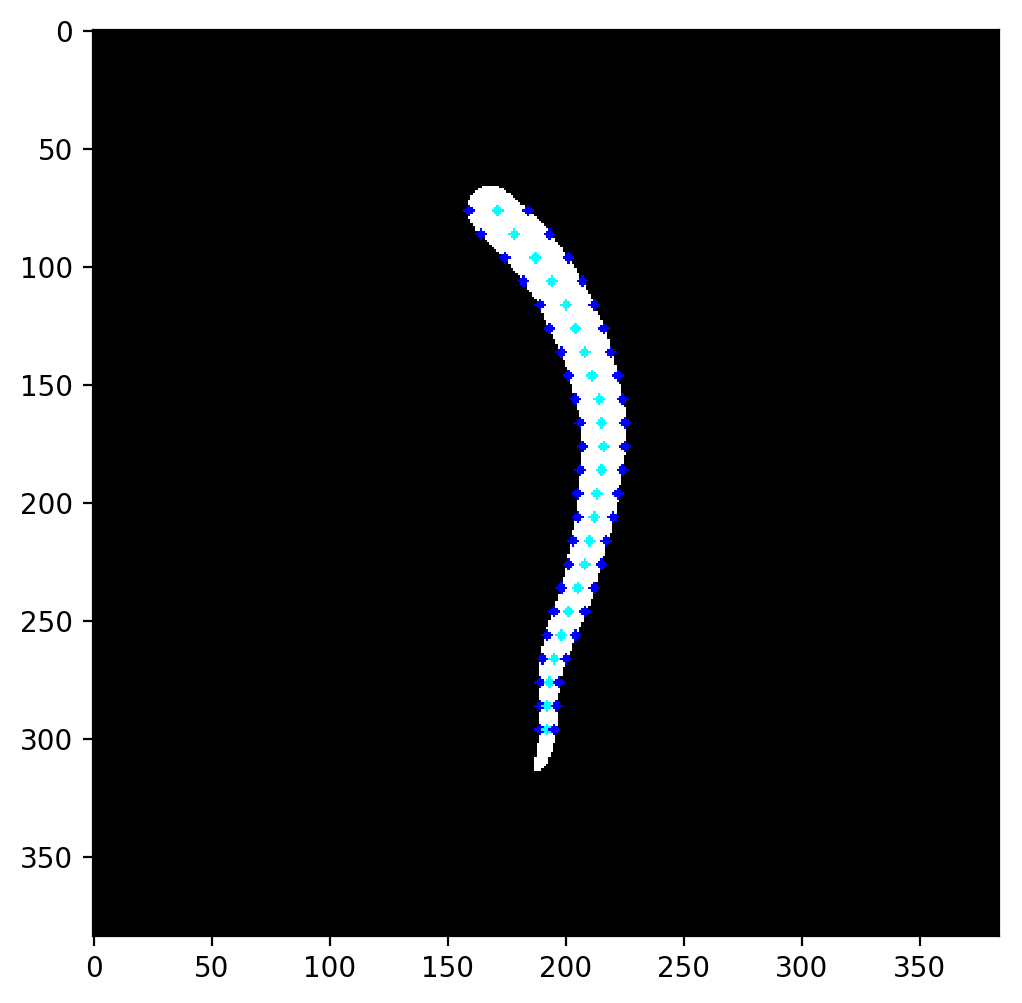

In [7]:
test = cv2.cvtColor(img6,cv2.COLOR_GRAY2BGR)
for p in tuples:
    cv2.circle(test,(p['l'][0],p['l'][1]),2,(255,0,0),-1)
    cv2.circle(test,(int(p['c'][0]),int(p['c'][1])),2,(255,255,0),-1)
    cv2.circle(test,(p['r'][0],p['r'][1]),2,(255,0,0),-1)
plt.figure(figsize=(6,6),dpi=200)
plt.imshow(test[:,:,::-1])

# ここまで

# ここから下はまだ検討中


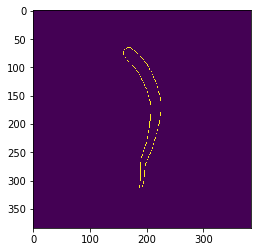

In [8]:
_img,cnt,hierarchy = cv2.findContours(img6, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
x0,y0,w,h = cv2.boundingRect(cnt[0])
Xs = cnt[0][:,0][:,0]
Ys = cnt[0][:,0][:,1]
cntimg = np.zeros_like(img6,np.uint8)
cntimg = cv2.drawContours(cntimg, [cnt[0]], 0, 255, thickness=1)
plt.imshow(cntimg)

In [9]:
def getNewsidePos(x1,y1,xc,yc):
        global cntimg
        dx = x1-xc
        dy = y1-yc
        s1 = int(xc + 1000*dy)
        t1 = int(yc - 1000*dx)
        s2 = int(xc - 1000*dy)
        t2 = int(yc + 1000*dx)
        cntimg = np.zeros_like(img6,np.uint8)
        cntimg = cv2.drawContours(cntimg, [cnt[0]], 0, 255, thickness=1)
        canvas = np.zeros_like(img6)
        canvas = cv2.line(canvas,(s1,t1),(s2,t2),255,1)
        canvas = cv2.bitwise_and(canvas,cntimg,cntimg)
        ps = np.argwhere(canvas==255)
        imin = np.argmin(ps[:,1])
        imax = np.argmax(ps[:,1])
        xl = ps[imin,1]
        yl = ps[imin,0]
        xr = ps[imax,1]
        yr = ps[imax,0]
        return xl,yl,xr,yr
    
tuples = []
# 初期のタプル
for i in range(y0+10,y0+h-10,10):
    xs = Xs[Ys==i]
    xl = min(xs)
    xr = max(xs)
    xc = (xl+xr)/2
    tuples.append({'l':[xl,i],'c':[xc,i],'r':[xr,i]})

test = cv2.cvtColor(img6,cv2.COLOR_GRAY2BGR)
for p in tuples:
    cv2.circle(test,(p['l'][0],p['l'][1]),2,(255,0,0),-1)
    cv2.circle(test,(int(p['c'][0]),int(p['c'][1])),1,(255,255,0),-1)
    cv2.circle(test,(p['r'][0],p['r'][1]),2,(255,0,0),-1)

for n in range(17):
    print("i",n)
    newtuples = []
    for i in range(len(tuples)-1,0,-1):
        global cntimg,cnt
        x1 = tuples[i-1]['c'][0]
        y1 = tuples[i-1]['c'][1]
        xc = tuples[i]['c'][0]
        yc = tuples[i]['c'][1]
        #    x2 = tuples[i+1]['c'][0]
        #    y2 = tuples[i+1]['c'][1]
        print("{0:0.1f},{1:0.1f},{2:0.1f},{3:0.1f}".format(x1,y1,xc,yc))
        xl,yl,xr,yr = getNewsidePos(x1,y1,xc,yc)
        xcnew = ((xl+xr)/2+9*xc)/10
        ycnew = ((yl+yr)/2+9*yc)/10
        newtuples.append({'l':[xl,yl],'c':[xcnew,ycnew],'r':[xr,yr]})
        print("[{},{}] -> [{},{}]".format(xc,yc,xcnew,ycnew))
    newtuples.append(tuples[0])
    tuples = newtuples

for p in newtuples:
    cv2.circle(test,(p['l'][0],p['l'][1]),7,(0,255,255),1)
    cv2.circle(test,(int(p['c'][0]),int(p['c'][1])),2,(0,0,0),1)
    cv2.circle(test,(p['r'][0],p['r'][1]),7,(0,255,255),1)
    
# 連続する３つの軸候補点から、その中央の点にふさわしい両側の点を求め、tuplesを更新する。
# def getsidepairs(x1,y1,xc,yc,x2,y2,Xs,Ys):
# 座標 (xc,yc) 軸上と想定される点、
# (x1,y1) 上の軸候補点
# (x2,y2) 下の軸候補点
# Xs,Ys 輪郭上の点

plt.figure(figsize=(6,6),dpi=200)
plt.imshow(test[:,:,::-1])

i 0
192.5,286.0,192.0,296.0
[192.0,296] -> [192.0,296.0]
193.0,276.0,192.5,286.0
[192.5,286] -> [192.5,286.0]
195.0,266.0,193.0,276.0
[193.0,276] -> [193.0,276.0]
198.0,256.0,195.0,266.0
[195.0,266] -> [194.5,265.9]
201.5,246.0,198.0,256.0
[198.0,256] -> [197.95,256.0]
205.0,236.0,201.5,246.0
[201.5,246] -> [201.55,246.0]
208.0,226.0,205.0,236.0
[205.0,236] -> [205.0,236.0]
210.0,216.0,208.0,226.0
[208.0,226] -> [207.95,225.95]
212.5,206.0,210.0,216.0
[210.0,216] -> [210.0,215.95]
213.5,196.0,212.5,206.0
[212.5,206] -> [212.5,205.95]
215.0,186.0,213.5,196.0
[213.5,196] -> [213.5,196.05]
216.0,176.0,215.0,186.0
[215.0,186] -> [214.95,186.0]
215.5,166.0,216.0,176.0
[216.0,176] -> [216.0,175.95]
214.0,156.0,215.5,166.0
[215.5,166] -> [215.55,166.05]
211.5,146.0,214.0,156.0
[214.0,156] -> [214.05,156.05]
208.5,136.0,211.5,146.0
[211.5,146] -> [211.5,146.0]
204.5,126.0,208.5,136.0
[208.5,136] -> [208.55,136.0]
200.5,116.0,204.5,126.0
[204.5,126] -> [204.5,126.0]
194.5,106.0,200.5,116.0
[200

ValueError: attempt to get argmin of an empty sequence

In [ ]:
cntimg = np.zeros_like(img6)
cntimg = cv2.drawContours(cntimg, [cnt[0]], 0, 1, thickness=1)
plt.imshow(img6)

In [ ]:
ps = xxxx(0,0,100,100,300,300)

In [ ]:
ps